<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#LyricsManager.py" data-toc-modified-id="LyricsManager.py-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LyricsManager.py</a></span></li><li><span><a href="#MoodyLyrics-issue" data-toc-modified-id="MoodyLyrics-issue-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MoodyLyrics issue</a></span></li><li><span><a href="#MoodyLyrics-and-MoodyLyrics4Q-comparison" data-toc-modified-id="MoodyLyrics-and-MoodyLyrics4Q-comparison-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MoodyLyrics and MoodyLyrics4Q comparison</a></span></li><li><span><a href="#New-features" data-toc-modified-id="New-features-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>New features</a></span><ul class="toc-item"><li><span><a href="#Feature-Analysis" data-toc-modified-id="Feature-Analysis-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Feature Analysis</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Feature Selection</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Artificial-Neural-Network" data-toc-modified-id="Artificial-Neural-Network-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Artificial Neural Network</a></span><ul class="toc-item"><li><span><a href="#Model" data-toc-modified-id="Model-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Cross-Validation" data-toc-modified-id="Cross-Validation-6.1.3"><span class="toc-item-num">6.1.3&nbsp;&nbsp;</span>Cross Validation</a></span></li><li><span><a href="#Analysis-on-Extra-Test" data-toc-modified-id="Analysis-on-Extra-Test-6.1.4"><span class="toc-item-num">6.1.4&nbsp;&nbsp;</span>Analysis on Extra Test</a></span></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#Analysis-on-Extra-Test" data-toc-modified-id="Analysis-on-Extra-Test-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Analysis on Extra Test</a></span></li></ul></li><li><span><a href="#SVM" data-toc-modified-id="SVM-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>SVM</a></span><ul class="toc-item"><li><span><a href="#Analysis-on-Extra-Test" data-toc-modified-id="Analysis-on-Extra-Test-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Analysis on Extra Test</a></span></li></ul></li><li><span><a href="#eXtreme-Gradient-Boost" data-toc-modified-id="eXtreme-Gradient-Boost-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>eXtreme Gradient Boost</a></span><ul class="toc-item"><li><span><a href="#Analysis-on-Extra-Test" data-toc-modified-id="Analysis-on-Extra-Test-6.4.1"><span class="toc-item-num">6.4.1&nbsp;&nbsp;</span>Analysis on Extra Test</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [96]:
import spacy
import os
import sys
import warnings
import itertools

import numpy as np
import pandas as pd

from utils.datasets import load_dataset_from_path, split_train_validation
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_color_codes()

#The below code is used to install external packages
import pip
def install(package):
    pip.main(['install', package])


emotion_labels = ['happy', 'sad', 'angry', 'relaxed']

In [2]:
# Read extra test set
extra_test_path = './datasets/extra_test.csv'
extra_test = pd.read_csv(extra_test_path)

In [71]:
"""
This function computes and plots the confusion matrix.
"""
def plot_confusion_matrix(y_true, y_pred, title, labels, filename):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    df_cnf_matrix = pd.DataFrame(data=cnf_matrix)
    plt.figure(figsize = (6,4))
    plt.title(title,fontsize=20)
    ax = sns.heatmap(df_cnf_matrix, annot=True, cmap='Blues',fmt='g',square=True,linewidths=.7, cbar_kws={"shrink": .5})
    ax.set_xticklabels(labels,fontsize=13, weight='bold', rotation=90)
    b = ax.set_yticklabels(labels,fontsize=13, weight='bold',rotation=360)
    plt.savefig(filename)

# Introduction
**Previously on Sara&Mario project**: 
<ol>
    <li>*MoodyLyrics* stats analysis</li>
    <li>Lyrics classification using the main classifiers</li>
    <li>Emotion classification by just considering the song title</li> 
</ol>
Now, following the last meeting discussion we: 
<ol>
    <li>Wrote a script to create the dataset *SpotifyURI*, *List of PlaylistIDs*, *MoodyLyric_Emotion*</li>
    <li>Wrote a script to detect all duplicated songs in MoodyLyrics to fill a bug report</li>
    <li>Added new features for the classification task</li>
</ol>

# LyricsManager.py
After downloading the Spotify RecSys Challenge dataset we wrote a script that: <br>
<ul>
    <li>Given as input: the *Spotify playlist dataset folder*, and an output folder, creates a data structure to store for each song:<br>
        <*SpotifyURI*, *PlaylistIDs*, *TrackInformation*, *Emotion*><br>
        where: 
            <ul>
                <li>*SpotifyURI* is the songID</li>
                <li>*PlaylistsIDs* is the list of playlist in which the song appear</li>
                <li>*TrackInformation* is the list of information taken from Spotify dataset</li>
                <li>*Emotion* is an optional field, present only if the song is also contained in the MoodyLyrics dataset, that contains the emotion label for the song
    </li>
            </ul>
      <li>Can load Spotify songs datastructure (if already existing)</li>
            <li>Given as input a SpotifyURI it can download lyrics from lyricwikia</li>
</ul>

# MoodyLyrics issue
Last week we detected duplicate information in MoodyLyrics. Now we can generate a .csv file capable of reporting those duplicates.

The bug report can be found at `./src/datasets/moodylyrics_bug_report.csv`.

# MoodyLyrics and MoodyLyrics4Q comparison
Here we are going to read MoodyLyrics and MoodyLyrics4Q and to compare the two class label distributions.

In [4]:
moodyLyrics4qDF = pd.read_csv('./datasets/MoodyLyrics4Q.csv')
moodyLyricsDF   = pd.read_csv('./datasets/moodylyrics_cleaned.csv')

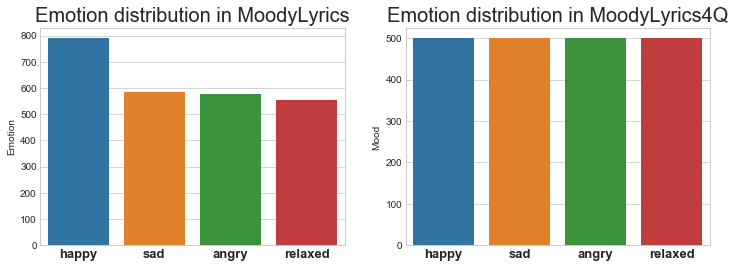

MoodyLyrics4Q size: 2000
MoodyLyrics size: 2509
MoodyLyrics4Q has 0 duplicates.


In [7]:
f, axarr = plt.subplots(1, 2, figsize=(12,4))
emotionDistribution = moodyLyricsDF.Emotion.value_counts()
ax = sns.barplot(x=np.array(range(4)),y=emotionDistribution, ax = axarr[0])
ax.set_title('Emotion distribution in MoodyLyrics',fontsize=20)
ax.set_xticklabels(emotion_labels,fontsize=13, fontweight='bold')

emotionDistribution = moodyLyrics4qDF.Mood.value_counts()
ax = sns.barplot(x=np.array(range(4)),y=emotionDistribution, ax = axarr[1])
ax.set_title('Emotion distribution in MoodyLyrics4Q',fontsize=20)
ax.set_xticklabels(emotion_labels,fontsize=13, fontweight='bold')
plt.savefig('./Advanced_feature_engineering_pictures/Stats.png')
plt.show()

## Compare size
print('MoodyLyrics4Q size:', len(moodyLyrics4qDF))
print('MoodyLyrics size:',len(moodyLyricsDF))

## Check if MoodyLyrics4q has duplicates as well
duplicatedCheck = moodyLyrics4qDF.groupby(['Artist','Title']).size().reset_index(name='count')
duplicatedRows = duplicatedCheck [(duplicatedCheck ['count']>1)]
print('MoodyLyrics4Q has', duplicatedRows.shape[0], 'duplicates.')

# New features
Starting from MoodyLyrics and MoodyLyrics4Q we are going to create a new dataset with a lot of new features. <br>
<ul>
    <li>**Title_vector**</li>
    <li>**Lyric_vector**</li>
    <li>**%Rhymes**:<br> defined as the percentage of the number of rhymes over the number of total lines. A rhyme is defined as a rhyme between two following lines.</li>
    <li>**%Past_tense_verbs**:<br> defined as the the percentage of the number of past tense verbs over the total number of verbs.</li>
    <li>**%Present_tense_verbs**:<br>  defined as the the percentage of the number of present tense verbs over the total number of verbs.</li>
    <li>**%Future_tense_verbs**:<br>  defined as the the percentage of the number of future tense verbs over the total number of verbs, where future is just will + base form.</li>
    <li>**%ADJ**:<br> Percentage of adjectives over the total number of words.</li>
    <li>**%ADP**:<br> Percentage of adpositions (e.g. in, to, during) over the total number of words.</li>
    <li>**%ADV**:<br> Percentage of adverbs (e.g. very, tomorrow, down, where, there) over the total number of words.</li>
    <li>**%AUX**:<br> Percentage of auxiliaries (e.g. is, has (done), will (do), should (do)) over the total number of words.</li>
    <li>**%INTJ**:<br> Percentage of interjections (e.g. psst, ouch, bravo, hello) over the total number of words.</li>
    <li>**%NOUN**:<br> Percentage of nouns over the total number of words.</li>
    <li>**%NUM**:<br> Percentage of numerals over the total number of words.</li>
    <li>**%PRON**:<br> Percentage of pronouns (e.g. I, you, he, she, myself, themselves, somebody,...) over the total number of words.</li> 
    <li>**%PROPN**:<br> Percentage of proper nouns (e.g. Mary, John) over the total number of words.</li>
    <li>**%PUNCT**:<br> Percentage of puntuctuation (e.g. ., (, ), ?) over the total number of words.</li>
    <li>**%VERB**:<br> Percentage of verbs over the total number of words.</li>
    <li>**Selfish_degree**:<br> Percentage of 'I' pronouns over the total number of pronouns</li>
    <li>**%Echoism**:<br> Percentage of echoism over the total number of words, where an echoism is either a sequence of two subsequent repeated words or the repetition of a vowel in a word. </li>
    <li>**%Duplicates**:<br> Percentage of duplicate words over the total number of words</li>
    <li>**isTitleInLyric**:<br> Boolean, true if the title string is also a substring of the lyric</li>
    <li>**sentiment**:<br> Sentiment between -1 and 1</li>
    <li>**subjectivity degree**:<br> Degree of subjectivity of the text</li>
</ul>

The sentiment and subjectivity analysis was done using [TextBlob](http://textblob.readthedocs.io/en/dev/index.html) Python NLP library.

## Feature Analysis

We already featurized the songs in MoodyLyrics and in MoodyLyrics4Q using the script that can be found at `./src/song_featurized.py`. We saved the resulting datasets in `./src/datasets/moodylyrics4q_featurized.csv` and in `./src/dataset/moodylyrics_featurized.csv`. <br>
Here we will build a model using both datasets. This behavior can be changed setting `use_both  = False` (in this case we'll use MoodyLyrics4Q alone.  

In [11]:
use_both = True
moodyLyrics4q_F = pd.read_csv('./datasets/moodylyrics4q_featurized.csv')
if use_both:
    print('Merging moodyLyrics and moodyLyrcs4Q...')
    moodyLyrics_F = pd.read_csv('./datasets/moodylyrics_featurized.csv')
    total_len = len(moodyLyrics4q_F ) + len(moodyLyrics_F )
    dataset = pd.concat([moodyLyrics4q_F , moodyLyrics_F])
    dataset.drop_duplicates(['ARTIST', 'SONG_TITLE'], inplace=True)
    print('Deleted duplicated songs: ',total_len - len(dataset))
else: 
    dataset = moodyLyrics4q_F
print('Final dataset shape:',dataset.shape)
print('*'*50)
print('Final dataset header: ', dataset.columns)

Merging moodyLyrics and moodyLyrcs4Q...
Deleted duplicated songs:  46
Final dataset shape: (4378, 38)
**************************************************
Final dataset header:  Index(['Unnamed: 0', 'ID', 'ARTIST', 'SONG_TITLE', 'LYRICS_VECTOR',
       'TITLE_VECTOR', 'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS',
       'SELFISH_DEGREE', 'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES',
       'VERB_PRESENT', 'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
       'CONJUCTION_FREQUENCIES', 'ADV_FREQUENCIES', 'AUX_FREQUENCIES',
       'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 'DETERMINER_FREQUENCIES',
       'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 'NUM_FREQUENCIES',
       'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES',
       'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES',
       'VERB_FREQUENCIES', 'X_FREQUENCIES', 'SPACE_FREQUENCIES', 'SENTIMENT',
       'SUBJECTIVITY', 'EMOTION'],
      dtype='object')


In the following cell we want to analyse the distribution of each variable.<br>
There are some features that we find useless for this analysis, i.e. `ID`, `ARTIST`, `SONG_TITLE`, `EMOTION`, while there are some other features we don't want to use in our classification task, i.e. `X_FREQUENCIES` and `SPACE_FREQUENCIES`. <br>
So the first step before this analysis is to drop all these columns.

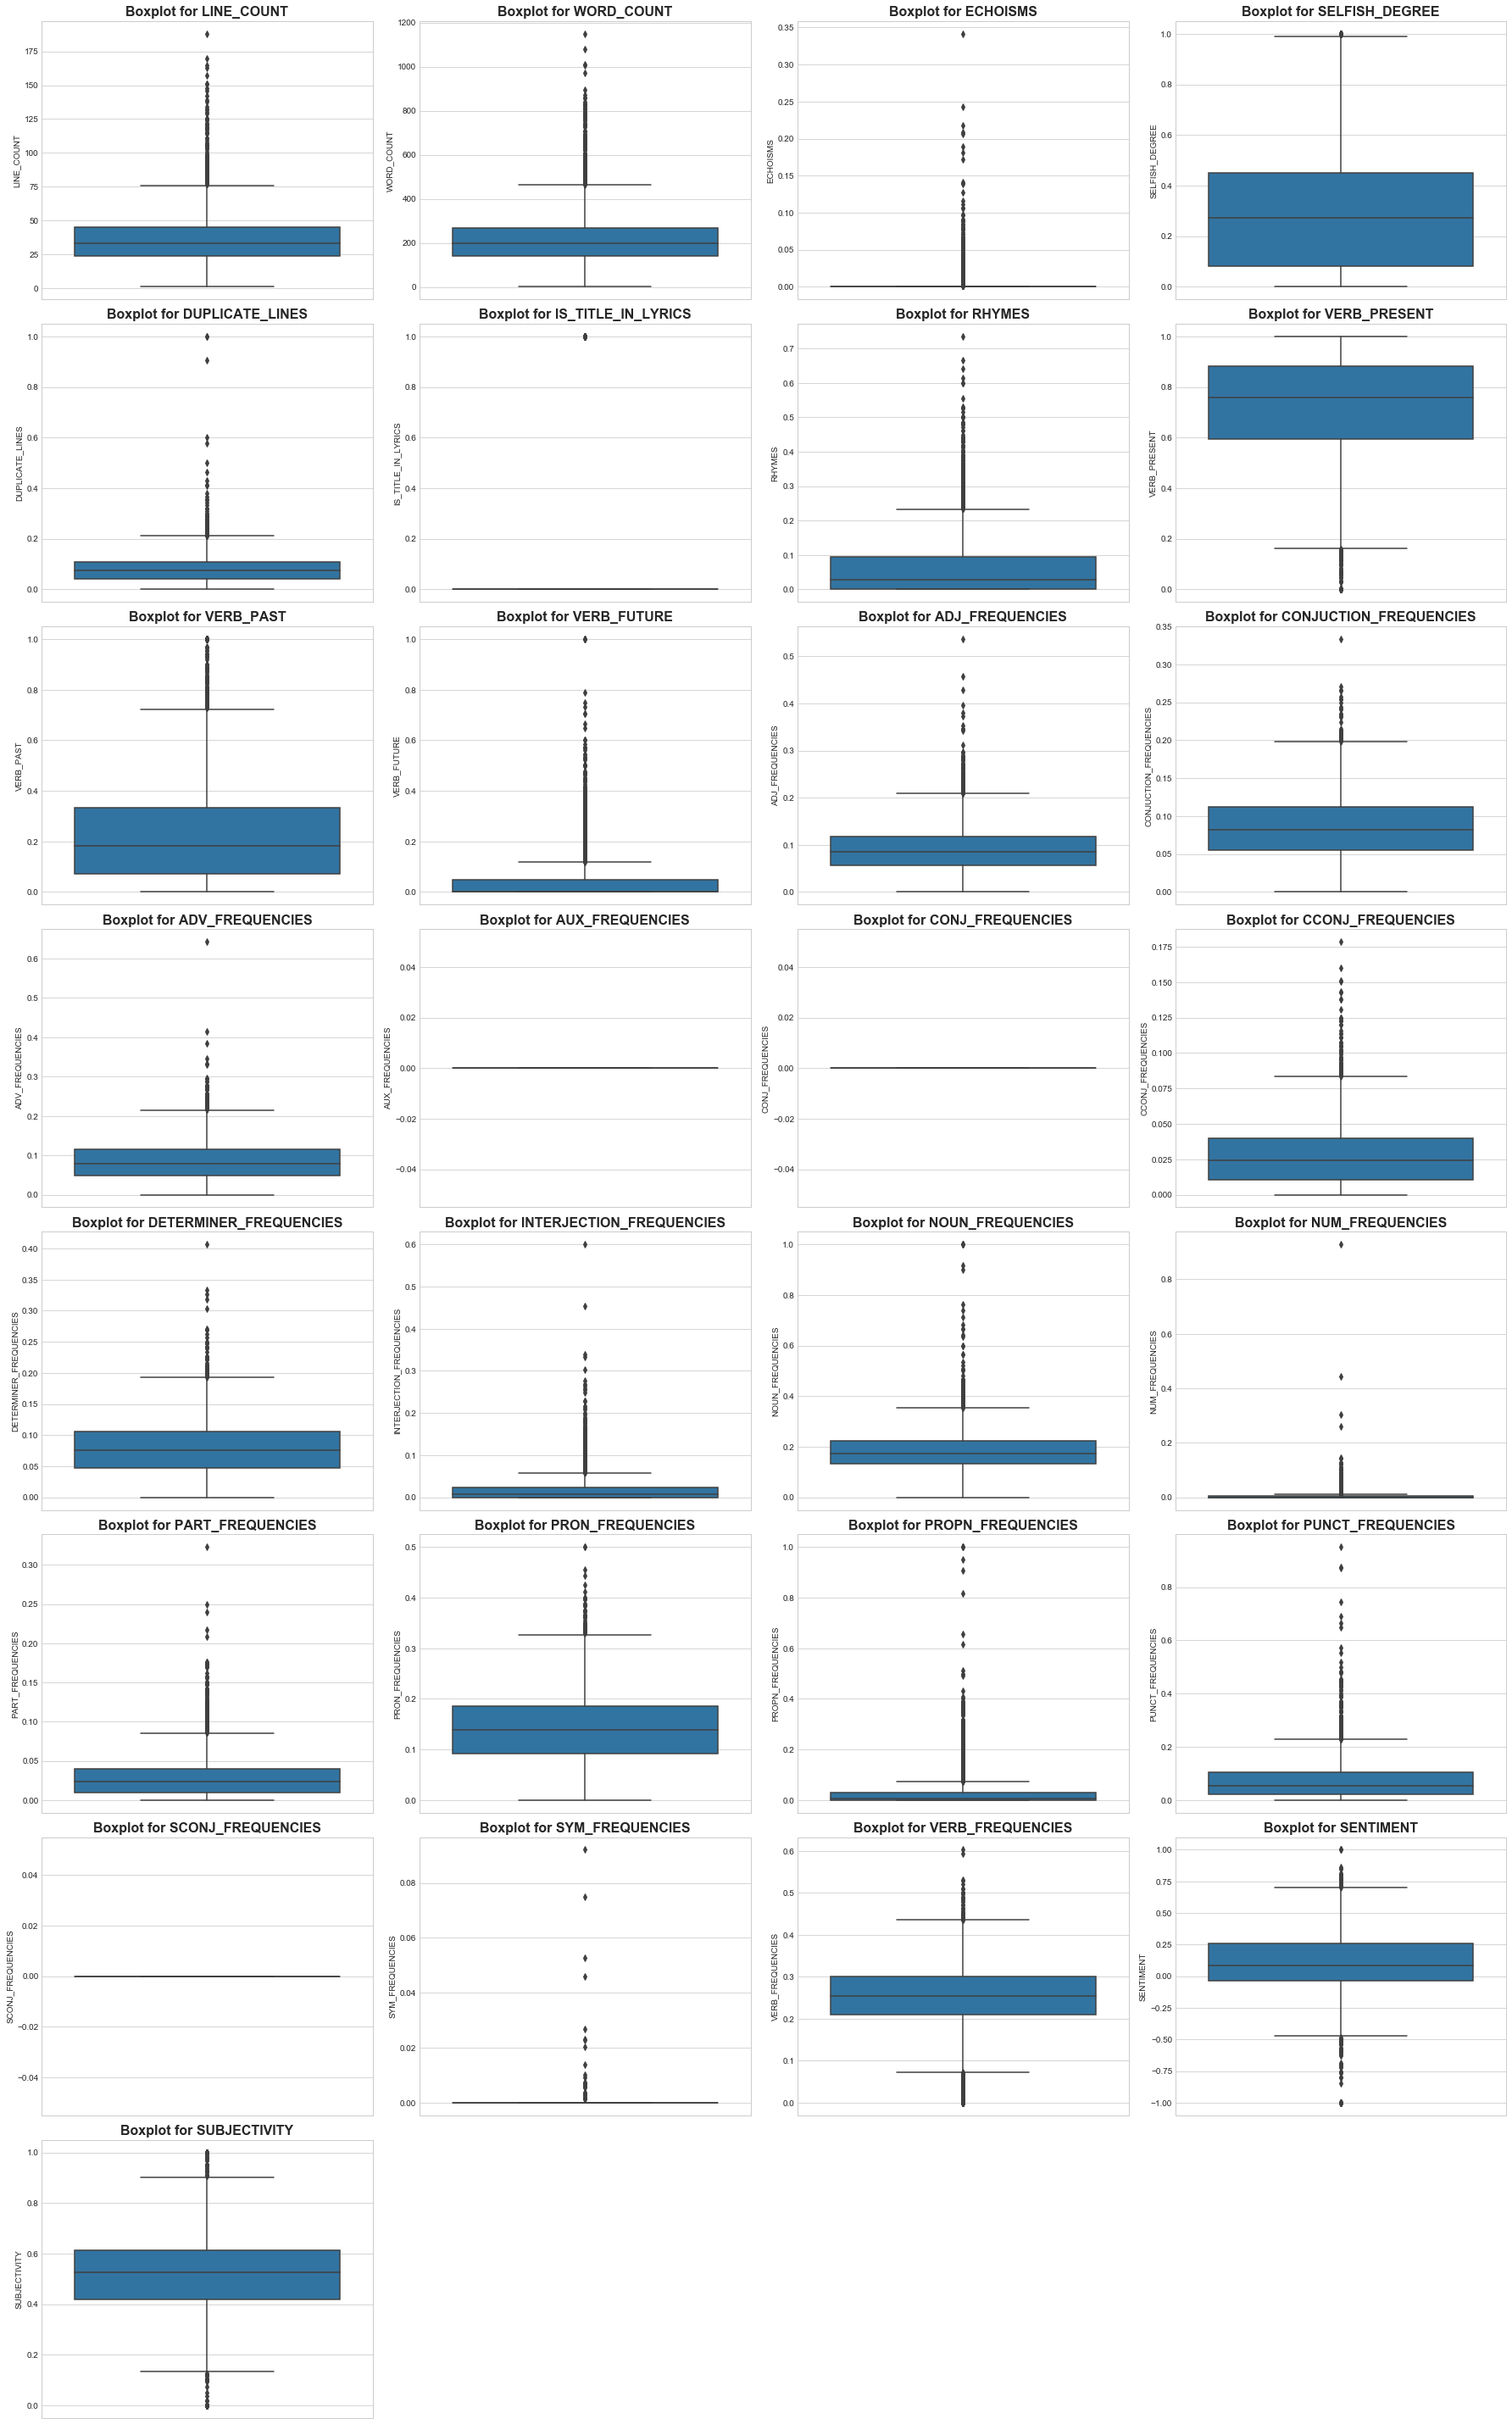

In [13]:
useless_columns = [ 'Unnamed: 0','ID','ARTIST', 'SONG_TITLE', 'EMOTION', 'X_FREQUENCIES', 'SPACE_FREQUENCIES']
tmp_df = dataset.drop(useless_columns + ['LYRICS_VECTOR', 'TITLE_VECTOR'],axis=1)

f, axarr = plt.subplots(8, 4, figsize=(25,40))
k = 0
for feature in tmp_df.columns:
    (i, j) = divmod(k, 4)
    axarr[i,j] = sns.boxplot(y=tmp_df[feature], ax=axarr[i,j])
    axarr[i,j].set_title('Boxplot for {}'.format(feature), fontsize=16, weight='bold')
    k += 1
plt.tight_layout()
f.delaxes(axarr[-1,-1])
f.delaxes(axarr[-1,-2])
f.delaxes(axarr[-1,-3])

## Feature Selection

In this section we want to select the most important feature for our classification.<br>
The final selection is the result of a lot trials that we don't want to show for the sake of brevity.

In [14]:
selected_columns = [
   'LYRICS_VECTOR',
   #'WORD_COUNT', 
   'ECHOISMS',
   #'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 
   'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY',
   'EMOTION'
]

In [15]:
'''
Function to get X and y of the correct shape. The function mainly transforms the lyrics array 
feature into 300 separate features. 
 X = (..., 310)
 y = (...,)
'''
def get_X_y(dataset, emotion=True):
    if emotion is True:
        tmp_df = dataset.drop(['EMOTION'], axis=1)
    else:
        tmp_df = dataset
    X = list()
    for (i, row) in tmp_df.iterrows():
        sub_list = list()
        for field in row:
            if type(field) == str:
                field = field[1:-1].split()
                sub_list += [float(x.replace('\n','')) for x in field]
            else:
                sub_list.append(field)
        X.append(np.array(sub_list))
    X = np.array(X)
    if emotion is True:
        y = dataset['EMOTION'].as_matrix().T
        return X, y
    else:
        return X

In [16]:
# Reduced dataset and extra_test
r_dataset = dataset[selected_columns]
r_extra_test = extra_test[selected_columns]

X, y = get_X_y(r_dataset)
X_extra_test, y_extra_test = get_X_y(r_extra_test)

In [18]:
print('X shape:', X.shape)
print('y shape:',y.shape)
print('X_extra_test shape:', X_extra_test.shape)
print('y_extra_test shape:',y_extra_test.shape)

X shape: (4378, 310)
y shape: (4378,)
X_extra_test shape: (20, 310)
y_extra_test shape: (20,)


# Classification

## Artificial Neural Network

### Model

Here we will use an ANN for our classification task. <br>
In the first cell we define the model.

In [69]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
    
from sklearn.utils import class_weight
    
def build_ann(optimizer='adam', input_size=310):
    classifier = Sequential()
    
    # Add input layer
    classifier = Sequential()
    # Add input layer
    classifier.add(Dense(units = 200, kernel_initializer = 'random_normal', activation = 'relu', input_dim = input_size))
    classifier.add(Dropout(0.1))
    
    # Add hidden layers
    classifier.add(Dense(units = 100, kernel_initializer = 'random_normal', activation = 'relu'))
    classifier.add(Dropout(0.1))
                

    classifier.add(Dense(units = 30, kernel_initializer = 'random_normal', activation = 'relu'))
    classifier.add(Dropout(0.1))
    
        
    # Add output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))
    
    # Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

Here we will encode y with numerical label and we'll scale X. 

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
'''
We encode y (i.e. angry, happy, sad, relaxed) into numerical label (0,1,2,3) and 
then into dummy variables... e.g. 0 0 1 0 instead of 2. 
and we scale X with a standard scaler
'''

encoder = LabelEncoder()
y_nn = np_utils.to_categorical(encoder.fit_transform(y))
sc = StandardScaler()
X_nn = sc.fit_transform(X)
print('New shapes...')
print('X shape', X_nn.shape)
print('y shape', y_nn.shape)

X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn, test_size = 0.1, random_state = 13)
emotion_labels = encoder.inverse_transform([0, 1, 2, 3])

New shapes...
X shape (4378, 310)
y shape (4378, 4)


/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [70]:
classifier = build_ann('adam', X_train.shape[1])
classifier.fit(X_train, y_train, batch_size = 128, epochs = 100, 
               validation_split=0.2, verbose=False)

### Results

Accuracy score 0.67


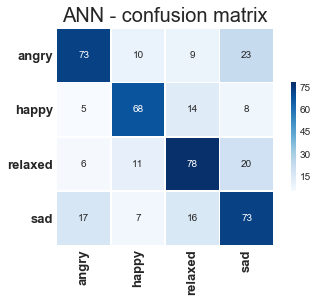

In [72]:
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test,axis=1)
filename = './Advanced_feature_engineering_pictures/CM_ANN.png'
plot_confusion_matrix(y_true, y_pred,'ANN - confusion matrix', emotion_labels, filename)

print('Accuracy score', round(accuracy_score(y_pred,y_true),2))

### Cross Validation

In [73]:
from keras.wrappers.scikit_learn import KerasClassifier

keras_classifier = KerasClassifier(build_fn=build_ann)
parameters = {'batch_size': [128, 256],
              'epochs': [100,200],
              'optimizer': ['rmsprop', 'adam']}
grid_search = GridSearchCV(estimator = keras_classifier,
                           param_grid = parameters,
                           cv = 5)
grid_search = grid_search.fit(X_nn, y_nn, verbose=0)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
best_classifier = grid_search.best_estimator_
print(best_parameters)
print('Accuracy: %0.2f' % (best_accuracy*100))

3503/3503 [==============================] - 0s 21us/step
{'batch_size': 256, 'epochs': 200, 'optimizer': 'adam'}
Accuracy: 67.63


### Analysis on Extra Test 

Let's see how our model performs on an extra test set defined by us.

New shapes...
X shape (20, 310)
y shape (20, 4)
Accuracy score 0.45


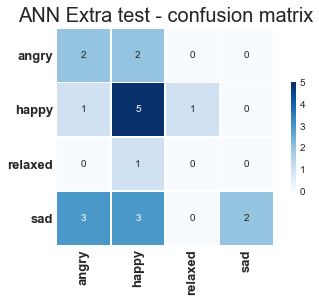

In [77]:
'''
We are going to use the encoder and the scaler previously trained
'''
y_extra_test_nn = np_utils.to_categorical(encoder.transform(y_extra_test))

X_extra_test_nn = sc.transform(X_extra_test)
print('New shapes...')
print('X shape',X_extra_test_nn.shape)
print('y shape',y_extra_test_nn.shape)

y_pred = classifier.predict(X_extra_test_nn)
y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_extra_test_nn,axis=1)
filename = './Advanced_feature_engineering_pictures/CM_ANN_extra.png'
plot_confusion_matrix(y_true, y_pred,'ANN Extra test - confusion matrix', emotion_labels, filename)

print('Accuracy score', round(accuracy_score(y_pred,y_true),2))

## Logistic Regression

In [85]:
encoder = LabelEncoder()
y_lr = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_lr, test_size = 0.1, random_state = 13)

In [86]:
from sklearn.linear_model import LogisticRegression
def evaluate_logreg(X_train, y_train, X_test):
    classifier = LogisticRegression(penalty='l2', dual=False, C=25,
                                    solver='newton-cg', multi_class='multinomial', random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    return y_pred

Accuracy: 0.68


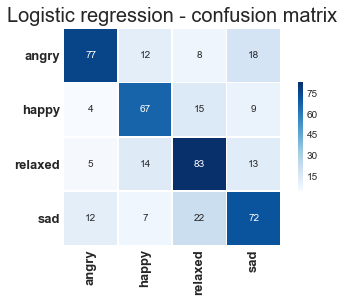

In [87]:
y_pred = evaluate_logreg(X_train, y_train, X_test)
print('Accuracy:', round(accuracy_score(y_test, y_pred),2))
filename = './Advanced_feature_engineering_pictures/CM_LR.png'
plot_confusion_matrix(y_test, y_pred, 'Logistic regression - confusion matrix', emotion_labels, filename)

### Analysis on Extra Test

Accuracy: 0.45


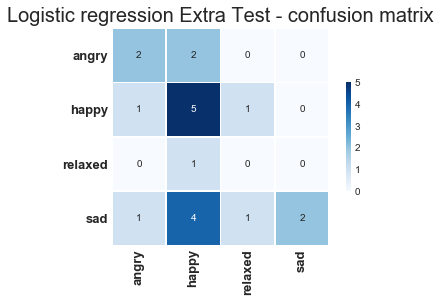

In [89]:
y_pred = evaluate_logreg(X_train, y_train, X_extra_test)
y_true = encoder.transform(y_extra_test)
print('Accuracy:', accuracy_score(y_true, y_pred))
filename = './Advanced_feature_engineering_pictures/CM_LR_extra.png'
plot_confusion_matrix(y_true, y_pred, 'Logistic regression Extra Test - confusion matrix', emotion_labels, filename)

## SVM 

In [90]:
encoder = LabelEncoder()
y_svm = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_svm, test_size = 0.1, random_state = 13)

Accuracy: 0.69


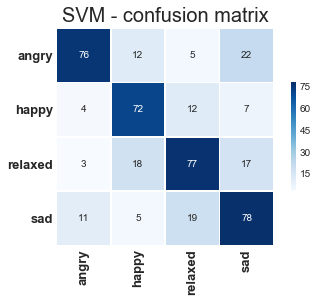

In [92]:
from sklearn.svm import SVC
clf = SVC(C=220, kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy:', round(accuracy_score(y_test, y_pred),2))
filename = './Advanced_feature_engineering_pictures/CM_SVM.png'
plot_confusion_matrix(y_test, y_pred, 'SVM - confusion matrix', emotion_labels, filename )

### Analysis on Extra Test

Accuracy: 0.55


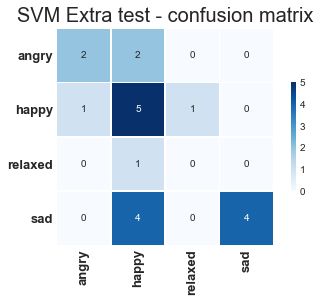

In [94]:
y_pred = clf.predict(X_extra_test)
y_true = encoder.transform(y_extra_test)
print('Accuracy:', round(accuracy_score(y_true, y_pred),2))
filename = './Advanced_feature_engineering_pictures/CM_SVM_extra.png'
plot_confusion_matrix(y_true, y_pred, 'SVM Extra test - confusion matrix', emotion_labels, filename )

## eXtreme Gradient Boost

In [98]:
import xgboost

/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 63.70%


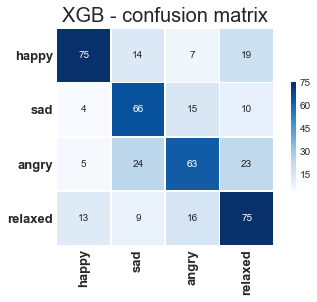

In [100]:
encoder = LabelEncoder()
y_xgb = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_xgb, test_size = 0.1, random_state = 13)
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
filename = './Advanced_feature_engineering_pictures/CM_XGB.png'
plot_confusion_matrix(y_test, y_pred, 'XGB - confusion matrix', emotion_labels, filename )

### Analysis on Extra Test 

/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.5


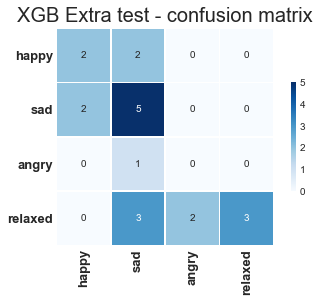

In [101]:
y_pred = xgb.predict(X_extra_test)
y_true = encoder.transform(y_extra_test)
print('Accuracy:', round(accuracy_score(y_true, y_pred),2))
filename = './Advanced_feature_engineering_pictures/CM_XGB_extra.png'
plot_confusion_matrix(y_true, y_pred, 'XGB Extra test - confusion matrix', emotion_labels, filename )

# Conclusion
